In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import os
import pandas as pd
import math
import seaborn as sns

from scipy.special import logsumexp
from pathlib import Path
from tqdm.auto import tqdm, trange

from bge_score_jax import BGe

/home/zj448/.conda/envs/jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dags_compressed = np.load('exact_posteriors/dags_7.npy')

In [4]:
dags_compressed.shape

(1138779265, 7)

In [9]:
datasets = ['ell', 'len', 'spr']
dfs, observations = {}, {}

for dataset in datasets:
    dfs[dataset] = pd.read_csv(f'R_e_data/causal_BH_{dataset}_distance.csv')
    dfs[dataset] = dfs[dataset].apply(lambda col: ( col - col.mean() ) / col.std(), axis=0)  # Standardize data
    observations[dataset] = np.asarray(dfs[dataset])

In [5]:
def compute_exact_posterior(dags_compressed, observations, batch_size=1, verbose=True):
    num_variables = observations.shape[1]
    model = BGe(num_variables=num_variables)

    @jax.jit
    def log_prob(observations, adjacencies_compressed):
        adjacencies = jnp.unpackbits(adjacencies_compressed, axis=1, count=num_variables ** 2)
        adjacencies = adjacencies.reshape(-1, num_variables, num_variables)

        v_log_prob = jax.vmap(model.log_prob, in_axes=(None, 0))
        log_probs = v_log_prob(observations, adjacencies)
        return jnp.sum(log_probs, axis=1)

    num_dags = dags_compressed.shape[0]
    log_probs = np.zeros((num_dags,), dtype=np.float32)
    for i in trange(0, num_dags, batch_size, disable=(not verbose)):
        # Get a batch of (compressed) DAGs
        batch_compressed = dags_compressed[i:i + batch_size]

        # Compute the BGe scores
        log_probs[i:i + batch_size] = log_prob(observations, batch_compressed)

    # Normalize the log-marginal probabilities
    log_probs = log_probs - logsumexp(log_probs)
    return log_probs

In [6]:
def edge_log_marginal(dags_compressed, log_joint, num_variables, batch_size=1, verbose=True):
    @jax.jit
    def marginalize(log_probs, adjacencies_compressed):
        adjacencies = jnp.unpackbits(adjacencies_compressed, axis=1, count=num_variables ** 2)
        log_probs = jnp.where(adjacencies == 1, log_probs[:, None], -jnp.inf)
        return jax.nn.logsumexp(log_probs, axis=0)

    num_dags = dags_compressed.shape[0]
    log_marginal = []
    for i in trange(0, num_dags, batch_size, disable=(not verbose)):
        # Get a batch of data
        batch_compressed = dags_compressed[i:i + batch_size]
        log_probs = log_joint[i:i + batch_size]

        log_marginal.append(marginalize(log_probs, batch_compressed))

    log_marginal = np.stack(log_marginal, axis=0)
    log_marginal = logsumexp(log_marginal, axis=0)
    return log_marginal.reshape(num_variables, num_variables)

## Distance

In [19]:
root = Path('/home/zj448/causal/jax-dag-gflownet/exact_posteriors')

log_edge_marginals = {}
for dataset in datasets:
    log_joint = compute_exact_posterior(dags_compressed, observations[dataset], batch_size=2048)
    log_edge_marginals[dataset] = edge_log_marginal(dags_compressed,
        log_joint, observations[dataset].shape[1], batch_size=4096)

    with open(root / f'log_joint_{dataset}_distance.npy', 'wb') as f:
        np.save(f, log_joint)

    with open(root / f'log_edge_marginal_{dataset}_distance.npy', 'wb') as f:
        np.save(f, log_edge_marginals[dataset])

100%|██████████| 278023/278023 [00:29<00:00, 9333.67it/s] 


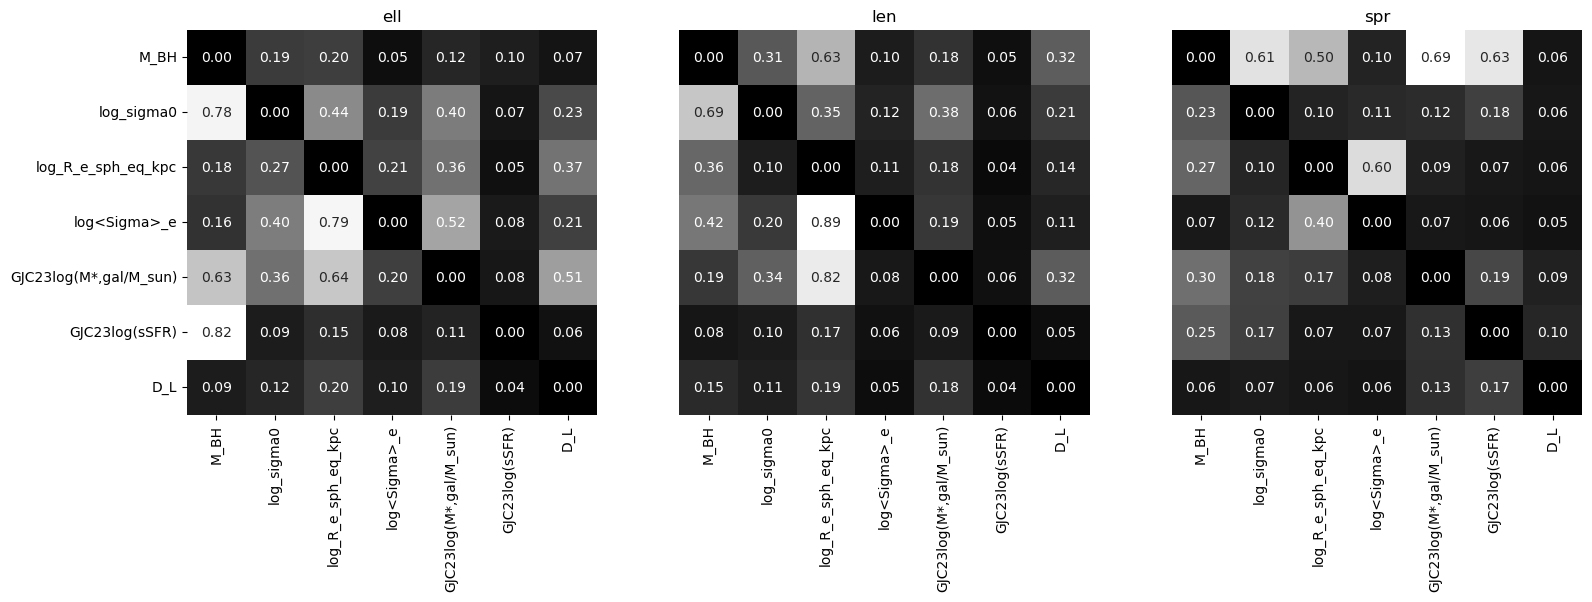

In [22]:
plt.figure(figsize=(18, 5))

for i, dataset in enumerate(datasets):
    ax = plt.subplot2grid((1, 3), (0, i))
    log_edge_marginal = np.load(root / f'log_edge_marginal_{dataset}_distance.npy')
    edge_marginal = pd.DataFrame(np.exp(log_edge_marginal),
        index=dfs[dataset].columns, columns=dfs[dataset].columns)

    sns.heatmap(edge_marginal, cmap='gray', ax=ax,
                annot=edge_marginal, fmt='.2f', cbar=False,
               yticklabels=i == 0)
    ax.set_title(dataset)
#plt.savefig('figures/edge_marginals.png', dpi=300)
plt.show()

In [7]:
def get_transitive_closure(adjacency):
    # Warshall's algorithm
    def scan_fun(closure, i):
        outer_product = jnp.outer(closure[:, i], closure[i])
        return (jnp.logical_or(closure, outer_product), None)
    
    adjacency = adjacency.astype(jnp.bool_)
    arange = jnp.arange(adjacency.shape[0])
    closure, _ = jax.lax.scan(scan_fun, adjacency, arange)

    return closure

def path_log_marginal(dags_compressed, log_joint, num_variables, batch_size=1, verbose=True):
    @jax.jit
    def marginalize(log_probs, adjacencies_compressed):
        adjacencies = jnp.unpackbits(adjacencies_compressed, axis=1, count=num_variables ** 2)
        adjacencies = adjacencies.reshape(-1, num_variables, num_variables)
        closures = jax.vmap(get_transitive_closure)(adjacencies)
        log_probs = jnp.where(closures, log_probs[:, None, None], -jnp.inf)
        return jax.nn.logsumexp(log_probs, axis=0)

    num_dags = dags_compressed.shape[0]
    log_marginal = []
    for i in trange(0, num_dags, batch_size, disable=(not verbose)):
        # Get a batch of data
        batch_compressed = dags_compressed[i:i + batch_size]
        log_probs = log_joint[i:i + batch_size]

        log_marginal.append(marginalize(log_probs, batch_compressed))

    log_marginal = np.stack(log_marginal, axis=0)
    log_marginal = logsumexp(log_marginal, axis=0)
    return log_marginal.reshape(num_variables, num_variables)

In [11]:
root = Path('/home/zj448/causal/jax-dag-gflownet/exact_posteriors')

log_path_marginals = {}
for dataset in datasets:
    log_joint = np.load(root / f'log_joint_{dataset}_distance.npy')
    log_path_marginals[dataset] = path_log_marginal(dags_compressed,
        log_joint, observations[dataset].shape[1], batch_size=1024)

    with open(root / f'log_path_marginal_{dataset}_distance.npy', 'wb') as f:
        np.save(f, log_path_marginals[dataset])

100%|██████████| 1112090/1112090 [02:40<00:00, 6915.33it/s]


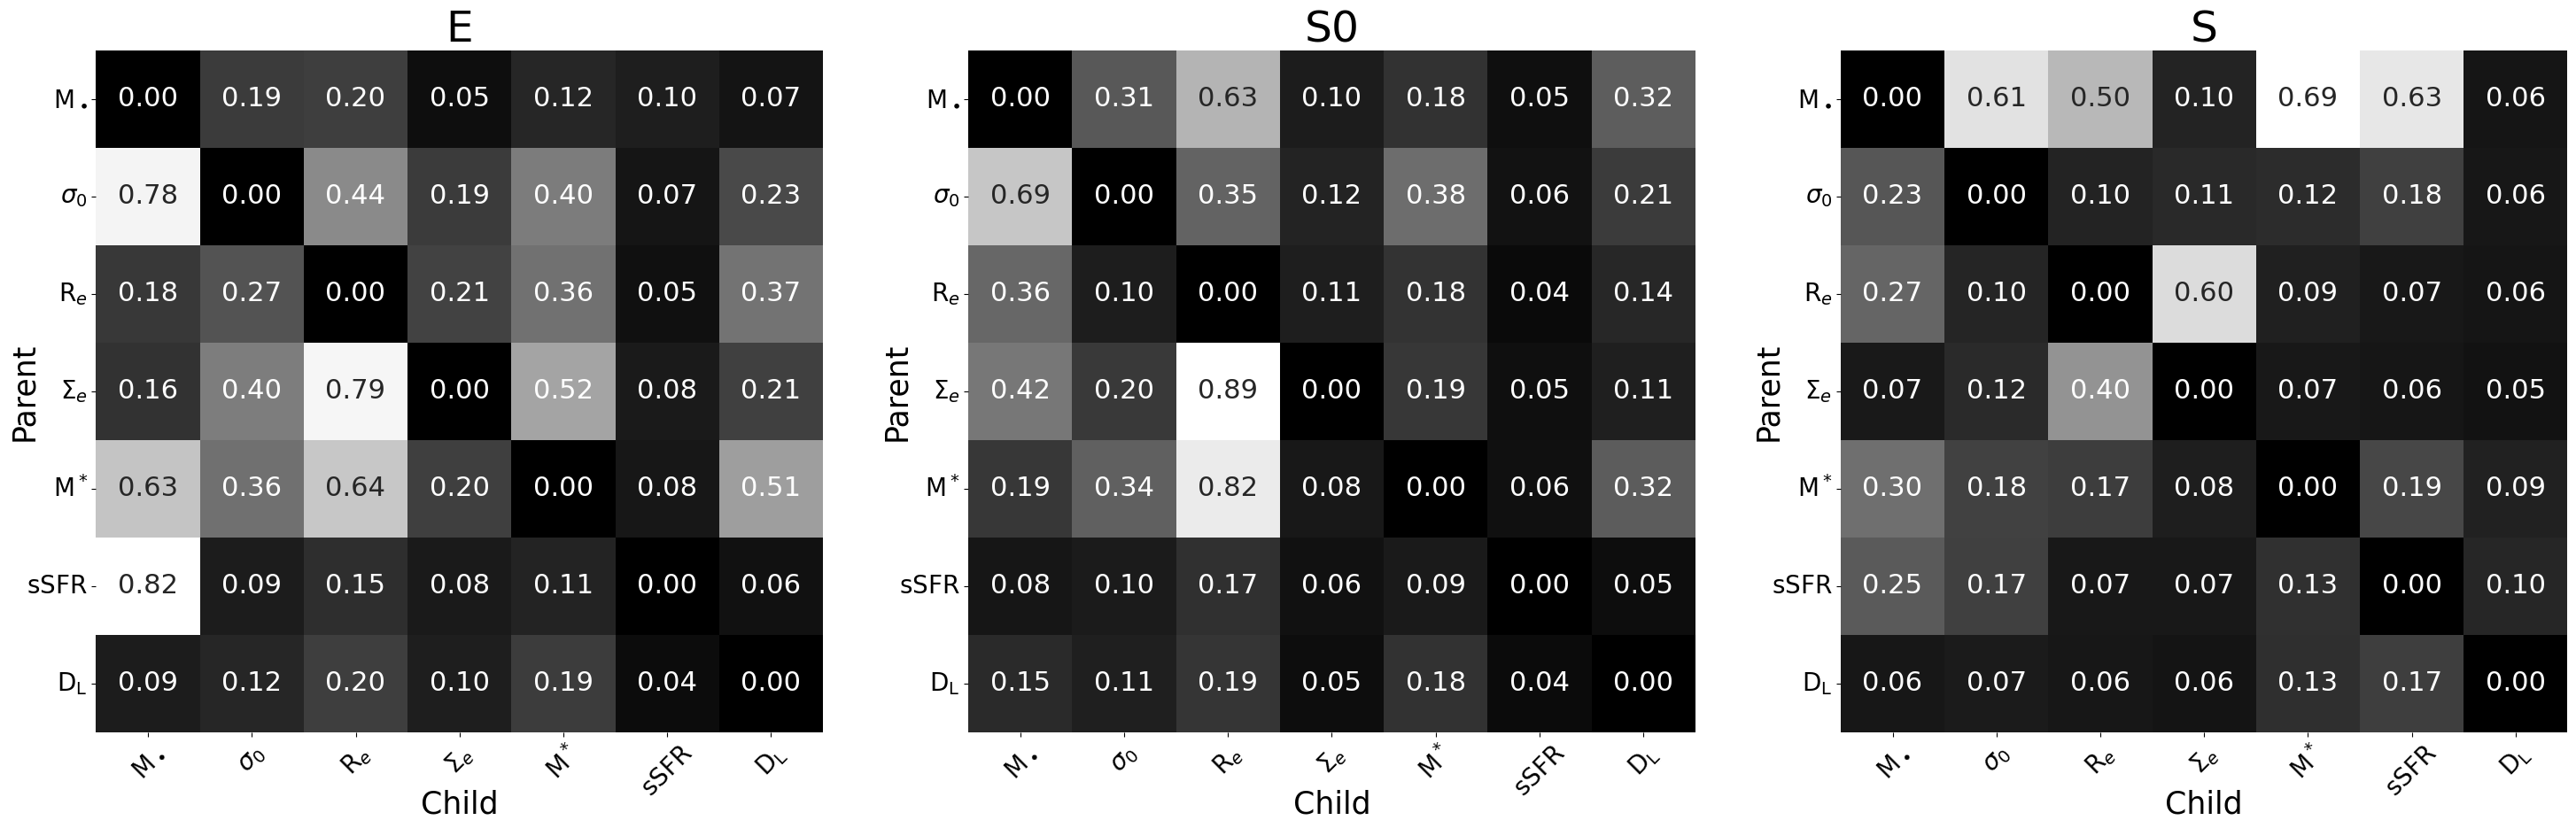

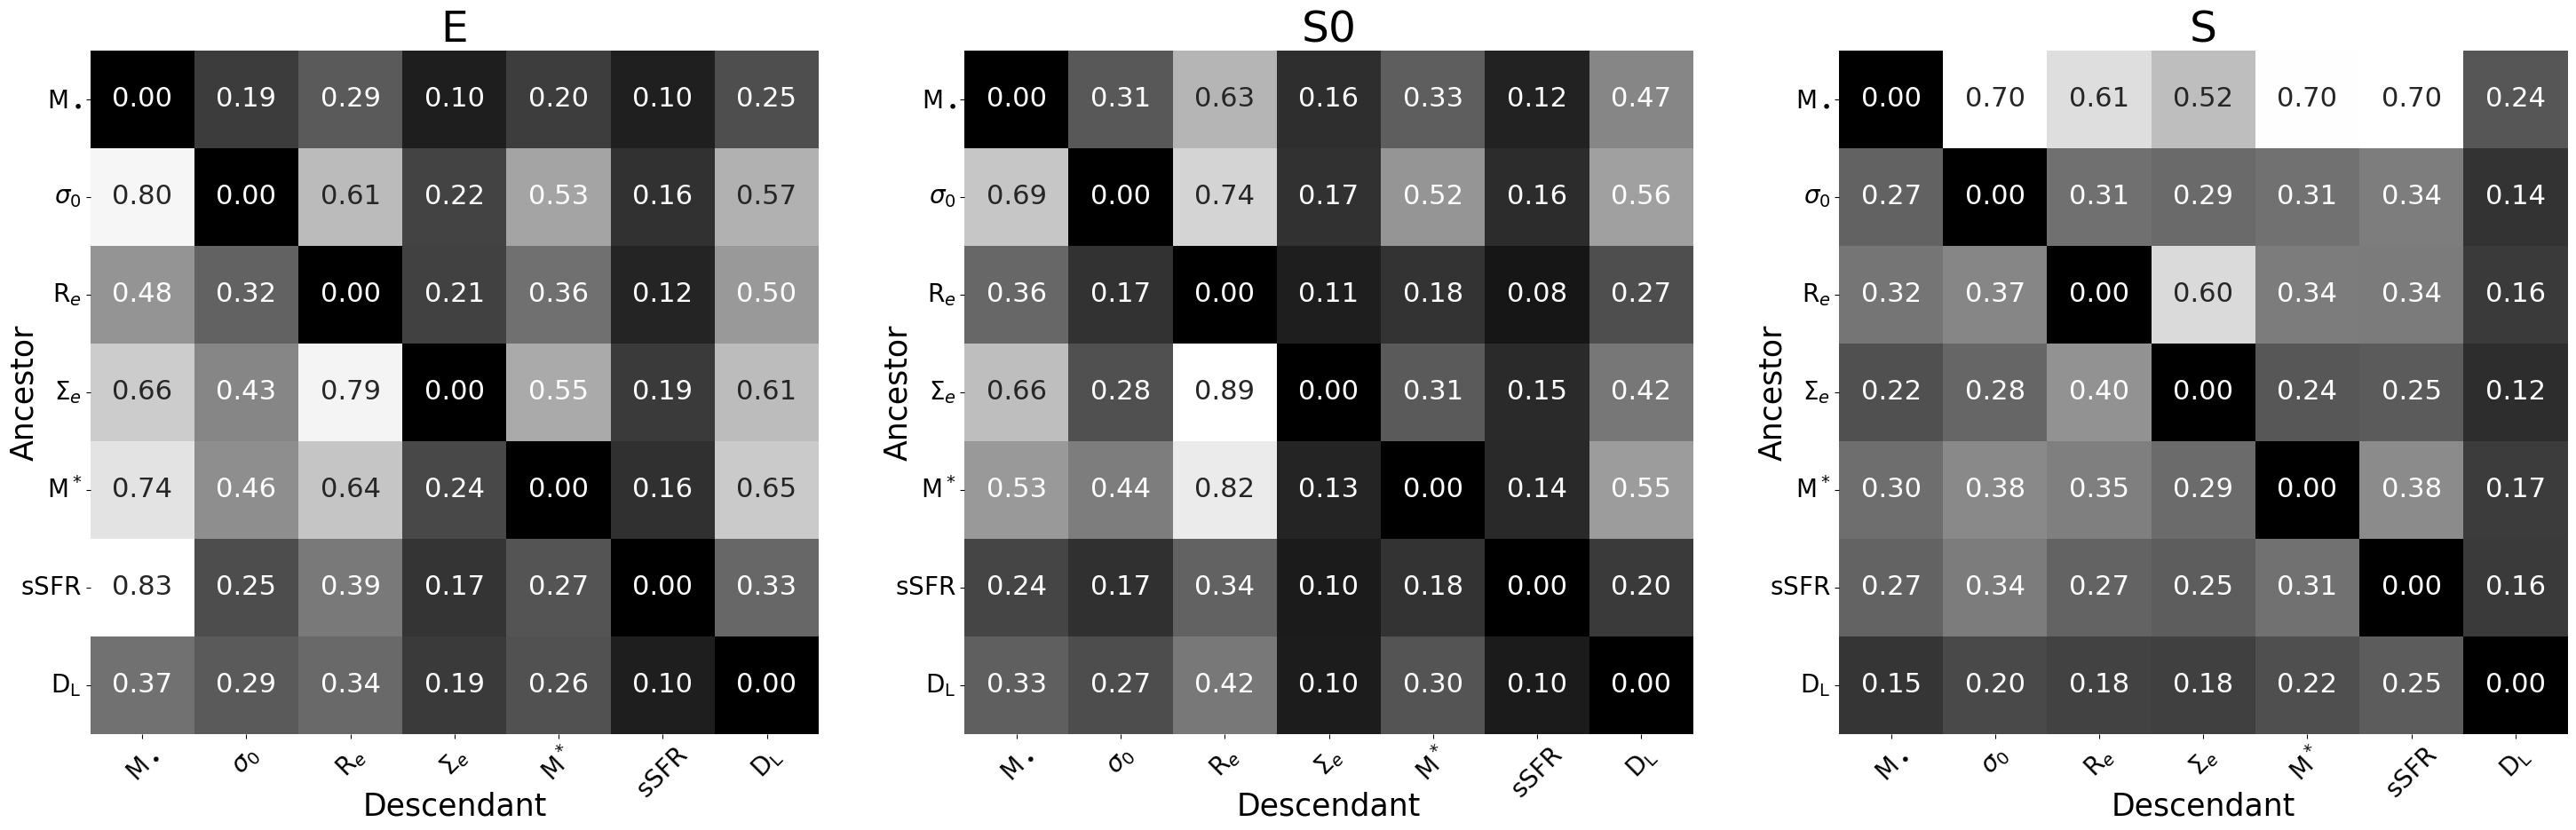

In [9]:
labels_list = [r'$\text{M}_\bullet$',r'$\sigma_0$', r'$\text{R}_e$', r'$\Sigma_e$',
       r'$\text{M}^*$', r'$\text{sSFR}$', r'$\text{D}_\text{L}$']

galtypes = ['ell','len','spr']
typename = {'ell':'E','len':'S0','spr':'S'}
root = Path('/home/zj448/causal/jax-dag-gflownet/exact_posteriors')

plt.figure(figsize=(36, 10))
#cmap = cmr.neutral
cmap='gray'


for i, galtype in enumerate(galtypes):
       log_edge_marginal = np.load(root / f'log_edge_marginal_{galtype}_distance.npy')
       marginal = np.exp(log_edge_marginal)
       ax = plt.subplot(1,3,i+1)  
       sns.heatmap(marginal, cmap=cmap, ax=ax,
              annot=marginal, annot_kws={"fontsize":22}, fmt='.2f', cbar=False)

       ax.set_title(typename[galtype],fontsize=35)
       ax.set_xticklabels(labels_list,rotation=45,fontsize=20)
       ax.set_yticklabels(labels_list,rotation=0,fontsize=20)
       ax.set_xlabel('Child',labelpad=-10,fontsize=25)
       ax.set_ylabel('Parent',labelpad=-10,fontsize=25)
       #plt.savefig('figures/edge_marginals.png', dpi=300)
plt.show()

plt.figure(figsize=(36, 10))
for i, galtype in enumerate(galtypes):
       log_path_marginal = np.load(root / f'log_path_marginal_{galtype}_distance.npy')
       marginal = np.exp(log_path_marginal)
       ax = plt.subplot(1,3,i+1)  
       sns.heatmap(marginal, cmap=cmap, ax=ax,
              annot=marginal, annot_kws={"fontsize":22}, fmt='.2f', cbar=False)

       ax.set_title(typename[galtype],fontsize=35)
       ax.set_xticklabels(labels_list,rotation=45,fontsize=20)
       ax.set_yticklabels(labels_list,rotation=0,fontsize=20)
       ax.set_xlabel('Descendant',labelpad=-10,fontsize=25)
       ax.set_ylabel('Ancestor',labelpad=-15,fontsize=25)
       #plt.savefig('figures/edge_marginals.png', dpi=300)
plt.show()


## 7 base variables

In [15]:
datasets = ['ell', 'len', 'spr']
dfs, observations = {}, {}

for dataset in datasets:
    dfs[dataset] = pd.read_csv(f'R_e_data/causal_BH_{dataset}.csv')
    dfs[dataset] = dfs[dataset].apply(lambda col: ( col - col.mean() ) / col.std(), axis=0)  # Standardize data
    observations[dataset] = np.asarray(dfs[dataset])

In [26]:
root = Path('/home/zj448/causal/jax-dag-gflownet/exact_posteriors')

log_edge_marginals = {}
for dataset in datasets:
    log_joint = compute_exact_posterior(dags_compressed, observations[dataset], batch_size=2048)
    log_edge_marginals[dataset] = edge_log_marginal(dags_compressed,
        log_joint, observations[dataset].shape[1], batch_size=4096)

    with open(root / f'log_joint_{dataset}.npy', 'wb') as f:
        np.save(f, log_joint)

    with open(root / f'log_edge_marginal_{dataset}.npy', 'wb') as f:
        np.save(f, log_edge_marginals[dataset])

  0%|          | 0/556045 [00:00<?, ?it/s]

100%|██████████| 278023/278023 [00:22<00:00, 12486.10it/s]


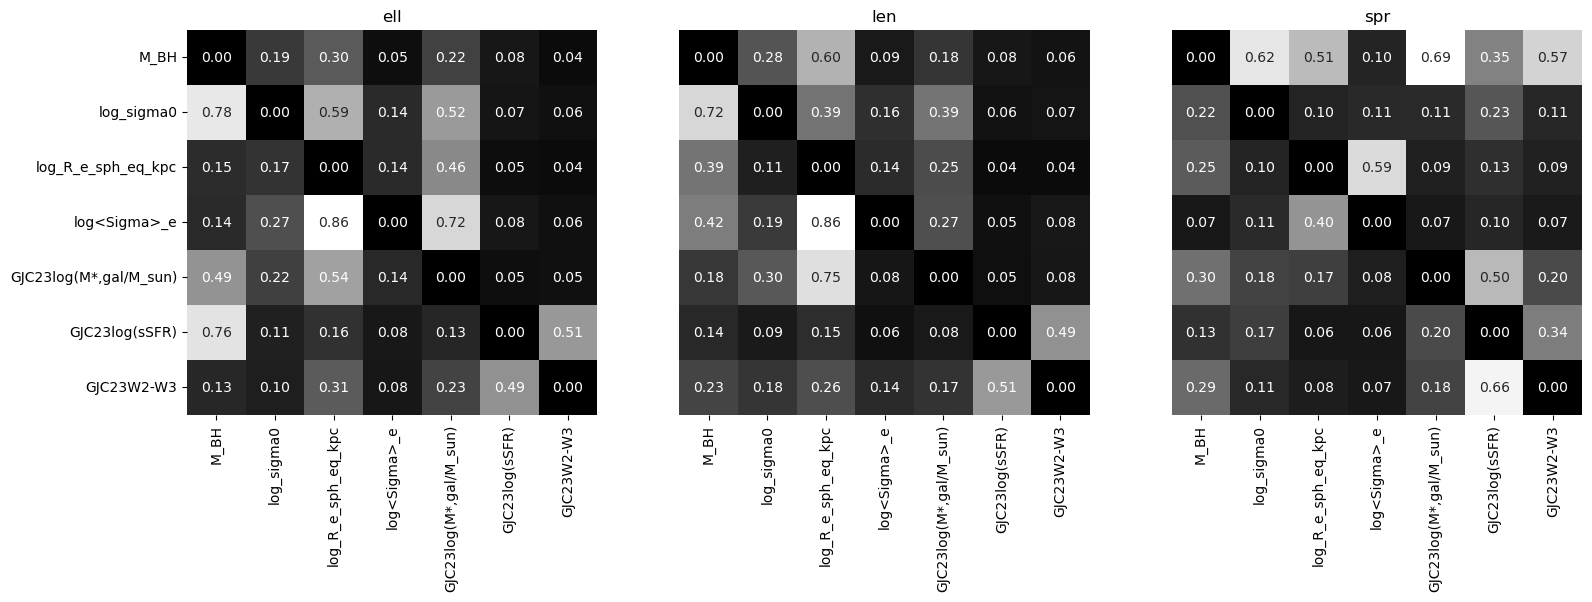

In [27]:
plt.figure(figsize=(18, 5))

for i, dataset in enumerate(datasets):
    ax = plt.subplot2grid((1, 3), (0, i))
    log_edge_marginal = np.load(root / f'log_edge_marginal_{dataset}.npy')
    edge_marginal = pd.DataFrame(np.exp(log_edge_marginal),
        index=dfs[dataset].columns, columns=dfs[dataset].columns)

    sns.heatmap(edge_marginal, cmap='gray', ax=ax,
                annot=edge_marginal, fmt='.2f', cbar=False,
               yticklabels=i == 0)
    ax.set_title(dataset)
#plt.savefig('figures/edge_marginals.png', dpi=300)
plt.show()

In [16]:
log_path_marginals = {}
for dataset in datasets:
    log_joint = np.load(root / f'log_joint_{dataset}.npy')
    log_path_marginals[dataset] = path_log_marginal(dags_compressed,
        log_joint, observations[dataset].shape[1], batch_size=1024)

    with open(root / f'log_path_marginal_{dataset}.npy', 'wb') as f:
        np.save(f, log_path_marginals[dataset])

100%|██████████| 1112090/1112090 [02:44<00:00, 6756.51it/s]


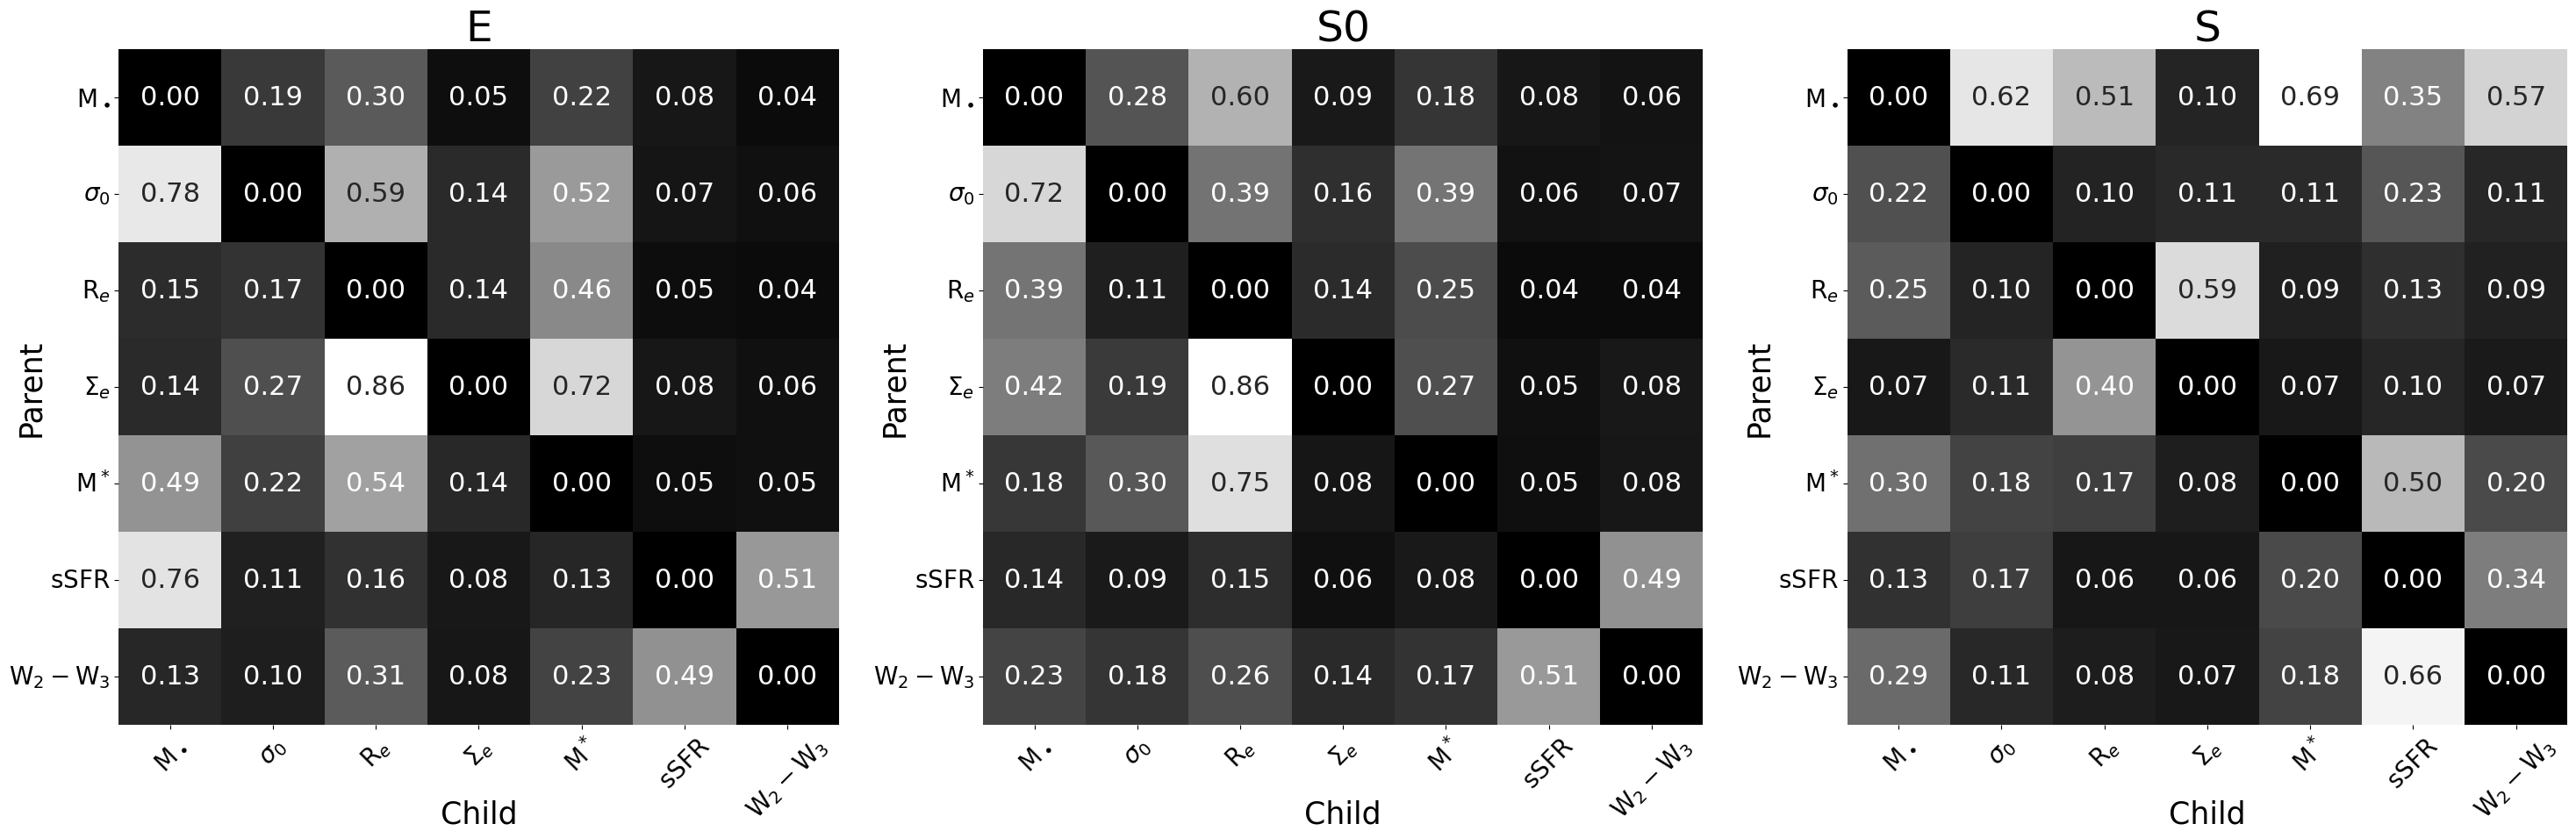

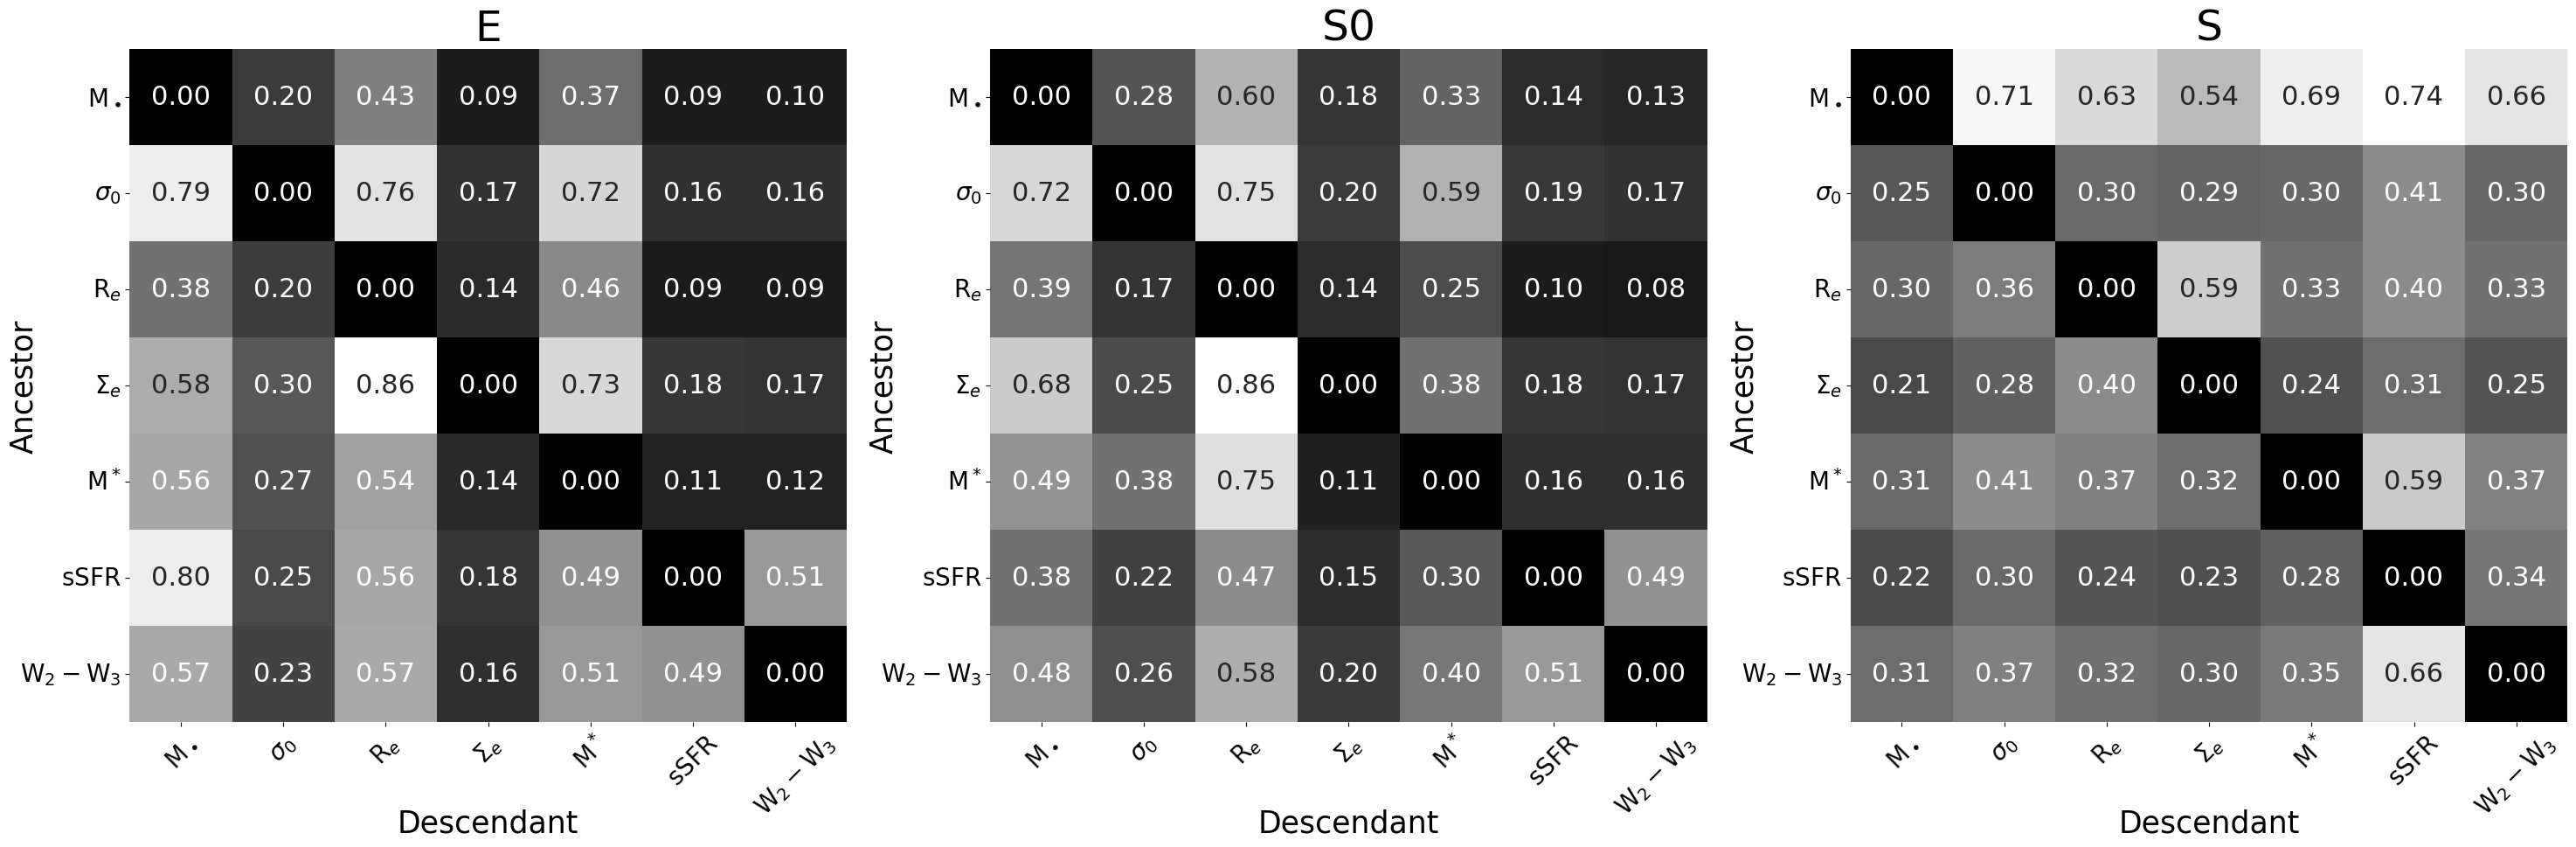

In [8]:
labels_list = [r'$\text{M}_\bullet$',r'$\sigma_0$', r'$\text{R}_e$', r'$\Sigma_e$',
       r'$\text{M}^*$', r'$\text{sSFR}$', r'$\text{W}_2-\text{W}_3$']

galtypes = ['ell','len','spr']
typename = {'ell':'E','len':'S0','spr':'S'}
root = Path('/home/zj448/causal/jax-dag-gflownet/exact_posteriors')

plt.figure(figsize=(36, 10))
#cmap = cmr.neutral
cmap='gray'


for i, galtype in enumerate(galtypes):
       log_edge_marginal = np.load(root / f'log_edge_marginal_{galtype}.npy')
       marginal = np.exp(log_edge_marginal)
       ax = plt.subplot(1,3,i+1)  
       sns.heatmap(marginal, cmap=cmap, ax=ax,
              annot=marginal, annot_kws={"fontsize":22}, fmt='.2f', cbar=False)

       ax.set_title(typename[galtype],fontsize=35)
       ax.set_xticklabels(labels_list,rotation=45,fontsize=20)
       ax.set_yticklabels(labels_list,rotation=0,fontsize=20)
       ax.set_xlabel('Child',labelpad=-20,fontsize=25)
       ax.set_ylabel('Parent',labelpad=-30,fontsize=25)
       #plt.savefig('figures/edge_marginals.png', dpi=300)
plt.show()

plt.figure(figsize=(36, 10))
for i, galtype in enumerate(galtypes):
       log_path_marginal = np.load(root / f'log_path_marginal_{galtype}.npy')
       marginal = np.exp(log_path_marginal)
       ax = plt.subplot(1,3,i+1)  
       sns.heatmap(marginal, cmap=cmap, ax=ax,
              annot=marginal, annot_kws={"fontsize":22}, fmt='.2f', cbar=False)

       ax.set_title(typename[galtype],fontsize=35)
       ax.set_xticklabels(labels_list,rotation=45,fontsize=20)
       ax.set_yticklabels(labels_list,rotation=0,fontsize=20)
       ax.set_xlabel('Descendant',labelpad=-10,fontsize=25)
       ax.set_ylabel('Ancestor',labelpad=-15,fontsize=25)
       #plt.savefig('figures/edge_marginals.png', dpi=300)
plt.show()
